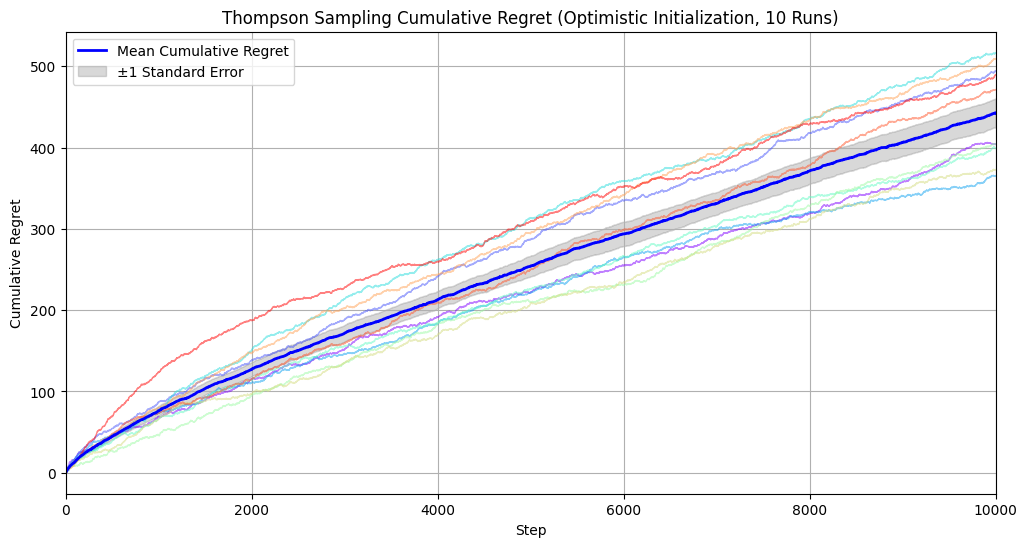

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import os

# Load preprocessed data
def load_preprocessed_data(save_path="./save"):
    with open(os.path.join(save_path, "arms.json"), "r") as f:
        arms = json.load(f)
    with open(os.path.join(save_path, "rewards.json"), "r") as f:
        rewards = json.load(f)
    return arms, rewards

# Thompson Sampling algorithm with optimistic initialization
def thompson_sampling(K, n, reward_lists, B):
    np.random.seed(int(time.time()))  # Set random seed
    random.seed(time.time())
    
    rewards, choices, regrets = [], [], []  # Record rewards, chosen arms, and regrets at each step
    empirical_means = np.zeros(K)  # Record the empirical mean reward for each arm
    action_counts = np.zeros(K)  # Record the number of times each arm is chosen
    
    # --- Optimistic initialization part ---
    # Initialize prior parameters: assume the initial mean of each arm is the maximum possible value (B), and variance is B^2/4
    prior_means = np.ones(K) * B  # Optimistic initialization: assume the initial mean of each arm is the maximum possible reward
    prior_variances = np.ones(K) * (B**2 / 4)  # Initial variance
    
    cumulative_regrets = np.zeros(n)  # Record cumulative regrets
    
    for t in range(1, n + 1):  # Iterate through each step
        # Sample a mean from the posterior distribution of each arm
        sample_means = np.random.normal(prior_means, np.sqrt(prior_variances))
        arm = np.argmax(sample_means)  # Choose the arm with the highest sampled mean
        
        # Randomly select a reward from the reward list of the chosen arm
        r = random.choice(reward_lists[arm])
        
        rewards.append(r)  # Record the reward
        choices.append(arm)  # Record the chosen arm
        action_counts[arm] += 1  # Update the number of times the arm is chosen
        
        # Update the empirical mean
        empirical_means[arm] = (empirical_means[arm] * (action_counts[arm] - 1) + r) / action_counts[arm]
        
        # Update the posterior distribution parameters
        prior_means[arm] = (prior_means[arm] * (action_counts[arm] - 1) + r) / action_counts[arm]
        prior_variances[arm] = (B**2 / 4) / action_counts[arm]
        
        # Calculate regret: the mean of the optimal arm minus the current reward
        best_arm_mean = np.max(empirical_means)
        regrets.append(best_arm_mean - r)
        cumulative_regrets[t - 1] = np.sum(regrets)  # Calculate cumulative regrets
    
    return cumulative_regrets

# Load preprocessed data
arms, rewards = load_preprocessed_data()
reward_lists = list(rewards.values())  # Use preprocessed rewards
K = len(arms)  # Number of arms (genres)

# Calculate B: the difference between the maximum and minimum ratings (for normalization)
B = 5  # Assuming the ratings are normalized to [0, 1]

# Parameter settings
n = 10000  # Total number of steps

# Run 10 experiments
num_runs = 10
all_cumulative_regrets = np.zeros((num_runs, n))

for i in range(num_runs):
    cumulative_regrets = thompson_sampling(K, n, reward_lists, B)
    all_cumulative_regrets[i, :] = cumulative_regrets

# Calculate the mean cumulative regrets and standard deviation
mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)
std_cumulative_regrets = np.std(all_cumulative_regrets, axis=0)
stderr_cumulative_regrets = std_cumulative_regrets / np.sqrt(num_runs)  # Standard error

# Plot the results
plt.figure(figsize=(12, 6))

# Plot each run's cumulative regrets with different colors
colors = plt.cm.rainbow(np.linspace(0, 1, num_runs))
for i in range(num_runs):
    plt.plot(all_cumulative_regrets[i, :], color=colors[i], alpha=0.5, linewidth=1)

# Plot the mean cumulative regrets and error bars
plt.plot(mean_cumulative_regrets, label='Mean Cumulative Regret', color='blue', linewidth=2)
plt.fill_between(range(n), 
                 mean_cumulative_regrets - stderr_cumulative_regrets, 
                 mean_cumulative_regrets + stderr_cumulative_regrets, 
                 color='gray', alpha=0.3, label='±1 Standard Error')

plt.title('Thompson Sampling Cumulative Regret (Optimistic Initialization, 10 Runs)')
plt.xlabel("Step")
plt.ylabel("Cumulative Regret")
plt.xlim(0, n)
plt.legend()
plt.grid(True)
plt.show()